In [10]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries and Spark Session


In [12]:
import pandas as pd
import io
import matplotlib.pyplot as plt
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import desc
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import sum,avg,max,min,mean,count,sqrt
from pyspark.sql.functions import col,when
from pyspark.sql import functions as F 
from pyspark.sql.functions import col,isnan, when, count
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns

In [13]:
#Initialize a spark session.
def spark_intialization():
    spark = SparkSession \
        .builder \
        .appName("Pyspark Project") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

In [14]:
# Initialise spark object
spark = spark_intialization()
spark

# DATA PREPROCESSING

In [15]:
from pyspark.sql import functions as pyspark_functions
from pyspark.sql.types import *
schema = StructType([ \
                     StructField("USER_ID", IntegerType(), True), \
                     StructField("Steam_Game", StringType(), True),\
                     StructField("Behaviour_Name", StringType(), True),\
                    StructField("Hours_played", FloatType(), True)])
dataframes = spark.read.schema(schema).csv("/content/drive/MyDrive/GOOGLE_COLAB/BigData/steam-200k.csv", header=False)
dataframes.show(10)

+---------+--------------------+--------------+------------+
|  USER_ID|          Steam_Game|Behaviour_Name|Hours_played|
+---------+--------------------+--------------+------------+
|151603712|The Elder Scrolls...|      purchase|         1.0|
|151603712|The Elder Scrolls...|          play|       273.0|
|151603712|           Fallout 4|      purchase|         1.0|
|151603712|           Fallout 4|          play|        87.0|
|151603712|               Spore|      purchase|         1.0|
|151603712|               Spore|          play|        14.9|
|151603712|   Fallout New Vegas|      purchase|         1.0|
|151603712|   Fallout New Vegas|          play|        12.1|
|151603712|       Left 4 Dead 2|      purchase|         1.0|
|151603712|       Left 4 Dead 2|          play|         8.9|
+---------+--------------------+--------------+------------+
only showing top 10 rows



In [16]:
dataframes = dataframes.withColumnRenamed("_c0","USER_ID").withColumnRenamed("_c1","Steam_Game").withColumnRenamed("_c2","Behaviour_Name").withColumnRenamed("_c3","Hours_played")
dataframes = dataframes.drop("_c4")
dataframes.show(10)

+---------+--------------------+--------------+------------+
|  USER_ID|          Steam_Game|Behaviour_Name|Hours_played|
+---------+--------------------+--------------+------------+
|151603712|The Elder Scrolls...|      purchase|         1.0|
|151603712|The Elder Scrolls...|          play|       273.0|
|151603712|           Fallout 4|      purchase|         1.0|
|151603712|           Fallout 4|          play|        87.0|
|151603712|               Spore|      purchase|         1.0|
|151603712|               Spore|          play|        14.9|
|151603712|   Fallout New Vegas|      purchase|         1.0|
|151603712|   Fallout New Vegas|          play|        12.1|
|151603712|       Left 4 Dead 2|      purchase|         1.0|
|151603712|       Left 4 Dead 2|          play|         8.9|
+---------+--------------------+--------------+------------+
only showing top 10 rows



**Exploratory Data Analysis**

In [17]:
total_records = dataframes.count()
print("Total records in dataframe", total_records)
# Find Count of Null, None, NaN of All DataFrame Columns
from pyspark.sql.functions import col,isnan, when, count
dataframes.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataframes.columns]
   ).show(truncate=False)

Total records in dataframe 200000
+-------+----------+--------------+------------+
|USER_ID|Steam_Game|Behaviour_Name|Hours_played|
+-------+----------+--------------+------------+
|0      |0         |0             |0           |
+-------+----------+--------------+------------+



In [20]:
#checking for duplicate values
#Hours if behavior is play, 1.0 if behavior is purchase
dataframes.groupBy("USER_ID","Steam_Game","Behaviour_Name", "Hours_played").count().filter("count > 1").show(5)
#no of duplicate rows 
print("Duplicate Values Count",dataframes.groupBy("USER_ID","Steam_Game","Behaviour_Name", "Hours_played").count().filter("count > 1").count())
#storing distinct datapoints of our dataset in distinctDF
df = dataframes.distinct()
print("Distinct count: "+str(df.count()))

+---------+--------------------+--------------+------------+-----+
|  USER_ID|          Steam_Game|Behaviour_Name|Hours_played|count|
+---------+--------------------+--------------+------------+-----+
| 71411882|Grand Theft Auto ...|      purchase|         1.0|    2|
| 53091150|Grand Theft Auto III|      purchase|         1.0|    2|
| 65152385|Sid Meier's Civil...|      purchase|         1.0|    2|
|101695880|Grand Theft Auto ...|      purchase|         1.0|    2|
| 73721802|Sid Meier's Civil...|      purchase|         1.0|    2|
+---------+--------------------+--------------+------------+-----+
only showing top 5 rows

Duplicate Values Count 707
Distinct count: 199293


In [21]:
#counting distinct users and games on the platform.
total_users = df.select(['USER_ID']).distinct().count()
total_games = df.select(['Steam_Game']).distinct().count()
total_hours = df.select(['Hours_played']).distinct().count()
print("Total No of Users  :", total_users)
print("Total No of Games :", total_games)
print("Total No of hours played by user :", total_hours)

Total No of Users  : 12393
Total No of Games : 5155
Total No of hours played by user : 1593


In [22]:
def sparsity(df):
    # Count the number of ratings in the rating dataframe
    hours_played = df.select("Hours_played").count()
    
    # Total Number of distinct users and animes
    total_element = total_users*total_games
    #print(total_element)
    # Calculate  % Sparsity of Matrix Fomrula (1-(rating_count)/(total_element))*100
    sparsity = (1-(hours_played)/total_element)*100
    print(" The dataframe is ", "%.2f" % sparsity +"% sparse")
sparsity(df)

 The dataframe is  99.69% sparse


In [23]:
#Most number of hours played Games
topGames=df.groupBy("Steam_Game") \
    .agg(count("Hours_played").alias("Hours")) \
    .sort(desc("Hours"))
topGames.show(10)

+--------------------+-----+
|          Steam_Game|Hours|
+--------------------+-----+
|              Dota 2| 9682|
|     Team Fortress 2| 4646|
|Counter-Strike Gl...| 2789|
|            Unturned| 2632|
|       Left 4 Dead 2| 1752|
|Counter-Strike So...| 1693|
|      Counter-Strike| 1424|
|         Garry's Mod| 1397|
|The Elder Scrolls...| 1394|
|            Warframe| 1271|
+--------------------+-----+
only showing top 10 rows



In [25]:
#Top paid Games 
topPurchaseGames = df.filter("Behaviour_Name == 'purchase'").groupBy("Steam_Game","Behaviour_Name").count().sort(desc("count"))
topPurchaseGames.show(10)

+--------------------+--------------+-----+
|          Steam_Game|Behaviour_Name|count|
+--------------------+--------------+-----+
|              Dota 2|      purchase| 4841|
|     Team Fortress 2|      purchase| 2323|
|            Unturned|      purchase| 1563|
|Counter-Strike Gl...|      purchase| 1412|
|Half-Life 2 Lost ...|      purchase|  981|
|Counter-Strike So...|      purchase|  978|
|       Left 4 Dead 2|      purchase|  951|
|      Counter-Strike|      purchase|  856|
|            Warframe|      purchase|  847|
|Half-Life 2 Death...|      purchase|  823|
+--------------------+--------------+-----+
only showing top 10 rows



In [27]:
#Top played Games 
topPlayedGames = df.filter("Behaviour_Name == 'play'").groupBy("Steam_Game","Behaviour_Name").count().sort(desc("count"))
topPlayedGames.show(10)

+--------------------+--------------+-----+
|          Steam_Game|Behaviour_Name|count|
+--------------------+--------------+-----+
|              Dota 2|          play| 4841|
|     Team Fortress 2|          play| 2323|
|Counter-Strike Gl...|          play| 1377|
|            Unturned|          play| 1069|
|       Left 4 Dead 2|          play|  801|
|Counter-Strike So...|          play|  715|
|The Elder Scrolls...|          play|  677|
|         Garry's Mod|          play|  666|
|      Counter-Strike|          play|  568|
|Sid Meier's Civil...|          play|  554|
+--------------------+--------------+-----+
only showing top 10 rows



In [28]:
dataframes.select("Hours_played").describe().show()

+-------+------------------+
|summary|      Hours_played|
+-------+------------------+
|  count|            200000|
|   mean|17.874384000420385|
| stddev| 138.0569516508248|
|    min|               0.1|
|    max|           11754.0|
+-------+------------------+



**Outlier Analysis**

In [29]:
#Calculate Upper, Lower and InterQuartlie Range
def calculate_bounds(df):
  c = "Hours_played"
  bounds = {
        c: dict(
            zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0))
        )
      
    }
  iqr = bounds[c]['q3'] - bounds[c]['q1']
  bounds[c]['min'] = bounds[c]['q1'] - (iqr * 1.5)
  bounds[c]['max'] = bounds[c]['q3'] + (iqr * 1.5)
  return bounds
#Indicate the presence of Outlier in the specic Column
def flag_outliers(df, id_col):
  bounds = calculate_bounds(df)
  outliers = {}
  c = "Hours_played"
  return df.select(c, id_col,
        *[
            F.when(
                ~F.col(c).between(bounds[c]['min'], bounds[c]['max']),
                "yes"
            ).otherwise("no").alias(c+'_outlier')
        ]
  )
#Columns Containing Outliers
outlier_data = flag_outliers(df,'USER_ID')
outlier_data.show(10)

+------------+---------+--------------------+
|Hours_played|  USER_ID|Hours_played_outlier|
+------------+---------+--------------------+
|        11.2| 53875128|                 yes|
|         1.0| 53875128|                  no|
|         1.9| 53875128|                  no|
|         1.4| 53875128|                  no|
|         0.4| 53875128|                 yes|
|         1.0|126340495|                  no|
|         9.2| 97298878|                 yes|
|         0.9| 97298878|                  no|
|       211.0| 48845802|                 yes|
|         1.0| 62923086|                  no|
+------------+---------+--------------------+
only showing top 10 rows



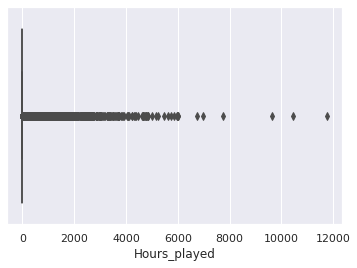

In [30]:
panda_df= df.toPandas()
sns.set()
ax = sns.boxplot(x=panda_df['Hours_played'])

# FEATURE ADDITION

In [32]:
new_feature =dataframes.filter("Hours_played >= 1")
new_feature.select("Behaviour_Name").distinct().collect()
new_feature.select('Steam_Game').distinct().count()
average = new_feature.groupBy("Steam_Game") \
             .agg(mean("Hours_played").alias("mean_Hourplayed")) \
             .select("Steam_Game", "mean_Hourplayed")
newfeature = new_feature.join(average, on="Steam_Game", how="inner")
newfeature.show(10)

+--------------------+---------+--------------+------------+------------------+
|          Steam_Game|  USER_ID|Behaviour_Name|Hours_played|   mean_Hourplayed|
+--------------------+---------+--------------+------------+------------------+
|The Elder Scrolls...|151603712|      purchase|         1.0|   52.523330890249|
|The Elder Scrolls...|151603712|          play|       273.0|   52.523330890249|
|           Fallout 4|151603712|      purchase|         1.0| 32.92108433971922|
|           Fallout 4|151603712|          play|        87.0| 32.92108433971922|
|               Spore|151603712|      purchase|         1.0|15.251724126010105|
|               Spore|151603712|          play|        14.9|15.251724126010105|
|   Fallout New Vegas|151603712|      purchase|         1.0| 25.46907563369815|
|   Fallout New Vegas|151603712|          play|        12.1| 25.46907563369815|
|       Left 4 Dead 2|151603712|      purchase|         1.0|20.613739546054582|
|       Left 4 Dead 2|151603712|        

In [33]:
# datapoints with less than 1 hour played games. We wont consider 16792 datapoints 
new_feature1 =dataframes.filter("Hours_played < 1")
new_feature1.count()

16792

In [34]:
from pyspark.sql.functions import when
newfeature = newfeature.withColumn("rating", 
                  when(newfeature["Hours_played"] == 1.0, 1)
                  .when(newfeature["Hours_played"] >= 0.9 * newfeature["mean_Hourplayed"], 5)
                   .when((newfeature["Hours_played"] >= 0.7 * newfeature["mean_Hourplayed"]) & (newfeature["Hours_played"] < 0.9 * newfeature["mean_Hourplayed"]), 4)
                   .when((newfeature["Hours_played"] >= 0.4 * newfeature["mean_Hourplayed"]) & (newfeature["Hours_played"] < 0.7 * newfeature["mean_Hourplayed"]), 3)
                   .when((newfeature["Hours_played"] >= 0.1 * newfeature["mean_Hourplayed"]) & (newfeature["Hours_played"] < 0.4 * newfeature["mean_Hourplayed"]), 2)
                   .otherwise(2))
newfeature.show()

+--------------------+---------+--------------+------------+------------------+------+
|          Steam_Game|  USER_ID|Behaviour_Name|Hours_played|   mean_Hourplayed|rating|
+--------------------+---------+--------------+------------+------------------+------+
|The Elder Scrolls...|151603712|      purchase|         1.0|   52.523330890249|     1|
|The Elder Scrolls...|151603712|          play|       273.0|   52.523330890249|     5|
|           Fallout 4|151603712|      purchase|         1.0| 32.92108433971922|     1|
|           Fallout 4|151603712|          play|        87.0| 32.92108433971922|     5|
|               Spore|151603712|      purchase|         1.0|15.251724126010105|     1|
|               Spore|151603712|          play|        14.9|15.251724126010105|     5|
|   Fallout New Vegas|151603712|      purchase|         1.0| 25.46907563369815|     1|
|   Fallout New Vegas|151603712|          play|        12.1| 25.46907563369815|     3|
|       Left 4 Dead 2|151603712|      purch

In [35]:
newfeature.groupBy("rating").count().show()

+------+------+
|rating| count|
+------+------+
|     1|130569|
|     3|  6185|
|     5| 29421|
|     4|  3181|
|     2| 13852|
+------+------+



## VISUALIZATION

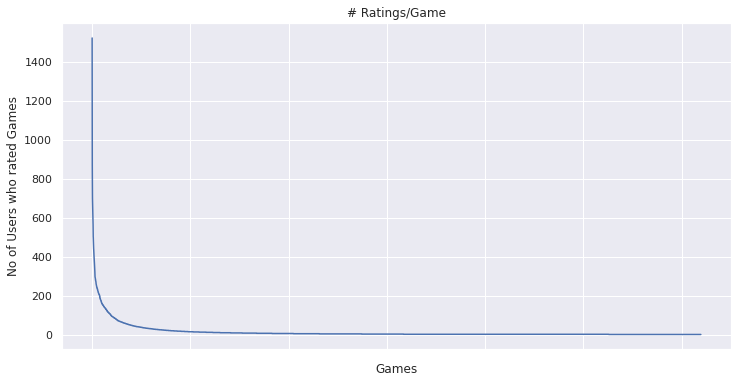

In [37]:
trainpd = newfeature.toPandas()
no_of_ratings_per_game = trainpd.groupby(by='USER_ID')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize = (12, 6))
ax = plt.gca()
plt.plot(no_of_ratings_per_game.values)
plt.title('# Ratings/Game')
plt.xlabel('Games')
plt.ylabel('No of Users who rated Games')
ax.set_xticklabels([])
plt.show()

# It is very skewed, just like the number of ratings given per user.
# There are some Games (which are very popular) which are rated by huge number of users.
# But most of the Games(like 90%) got some 0-100 of user ratings only.

Vishanth Model Implementation

In [38]:
newfeature.count()

183208

**ALS IMPLEMENTATION**

In [40]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator


In [44]:
newfeature.printSchema()
pandasdf = newfeature.toPandas()
pandasdf['Steam_Game'] = pandasdf['Steam_Game'].astype('category')
d = dict(enumerate(pandasdf['Steam_Game'].cat.categories))
pandasdf['GAME_ID'] = pandasdf['Steam_Game'].cat.codes
pandasdf.head(10)

root
 |-- Steam_Game: string (nullable = true)
 |-- USER_ID: integer (nullable = true)
 |-- Behaviour_Name: string (nullable = true)
 |-- Hours_played: float (nullable = true)
 |-- mean_Hourplayed: double (nullable = true)
 |-- rating: integer (nullable = false)



,Steam_Game,USER_ID,Behaviour_Name,Hours_played,mean_Hourplayed,rating,GAME_ID
0,The Elder Scrolls V Skyrim,151603712,purchase,1.0,52.523331,1,4364
1,The Elder Scrolls V Skyrim,151603712,play,273.0,52.523331,5,4364
2,Fallout 4,151603712,purchase,1.0,32.921084,1,1678
3,Fallout 4,151603712,play,87.0,32.921084,5,1678
4,Spore,151603712,purchase,1.0,15.251724,1,3997
5,Spore,151603712,play,14.9,15.251724,5,3997
6,Fallout New Vegas,151603712,purchase,1.0,25.469076,1,1679
7,Fallout New Vegas,151603712,play,12.1,25.469076,3,1679
8,Left 4 Dead 2,151603712,purchase,1.0,20.613740,1,2475
9,Left 4 Dead 2,151603712,play,8.9,20.613740,3,2475


In [45]:
newfeature = spark.createDataFrame(pandasdf)
newfeature.show(10)

+--------------------+---------+--------------+------------------+------------------+------+-------+
|          Steam_Game|  USER_ID|Behaviour_Name|      Hours_played|   mean_Hourplayed|rating|GAME_ID|
+--------------------+---------+--------------+------------------+------------------+------+-------+
|The Elder Scrolls...|151603712|      purchase|               1.0|   52.523330890249|     1|   4364|
|The Elder Scrolls...|151603712|          play|             273.0|   52.523330890249|     5|   4364|
|           Fallout 4|151603712|      purchase|               1.0| 32.92108433971922|     1|   1678|
|           Fallout 4|151603712|          play|              87.0| 32.92108433971922|     5|   1678|
|               Spore|151603712|      purchase|               1.0|15.251724126010105|     1|   3997|
|               Spore|151603712|          play|14.899999618530273|15.251724126010105|     5|   3997|
|   Fallout New Vegas|151603712|      purchase|               1.0| 25.46907563369815|     1

In [46]:
train, test = newfeature.randomSplit([0.8, 0.2])

In [47]:
from pyspark.sql.functions import avg
## Calculating user-item interaction
# Calculate User Mean
userMeanDF = train.groupBy('USER_ID').agg({'rating': 'mean'}).withColumnRenamed("avg(rating)", "user_mean")
# Calculate Anime Mean
itemMeanDF = train.groupBy('GAME_ID').agg({'rating': 'mean'}).withColumnRenamed("avg(rating)", "item_mean")
# Calculate Global Average in Train set
globalAverageDF = train.select(avg('rating'))
globalAverage = globalAverageDF.collect()[0]['avg(rating)']
# Adding the mean columns to train DF
meanDF = train.join(userMeanDF, ['USER_ID'], "inner").join(itemMeanDF, ['GAME_ID'], "inner")
#create final DF with user-item interaction column
interactionDF = meanDF.withColumn('user_item_interaction', meanDF['rating']-(meanDF['user_mean'] + meanDF['item_mean'] - globalAverage))
interactionDF.show(5)

+-------+---------+--------------------+--------------+-----------------+------------------+------+------------------+-----------------+---------------------+
|GAME_ID|  USER_ID|          Steam_Game|Behaviour_Name|     Hours_played|   mean_Hourplayed|rating|         user_mean|        item_mean|user_item_interaction|
+-------+---------+--------------------+--------------+-----------------+------------------+------+------------------+-----------------+---------------------+
|     81|158159336|        APB Reloaded|          play|              5.5|25.836784740884557|     2|1.3076923076923077|1.564625850340136|   0.9641509845126135|
|     81|158159336|        APB Reloaded|      purchase|              1.0|25.836784740884557|     1|1.3076923076923077|1.564625850340136| -0.03584901548738...|
|    109|142799594|AdVenture Capitalist|      purchase|              1.0|19.304923077363235|     1|1.8571428571428572|1.745019920318725|  -0.7656936349165246|
|    109|158159336|AdVenture Capitalist|      

In [48]:
interactionDF.drop("Steam_Game","Behaviour_Name","Hours_played","mean_Hourplayed") \
    .printSchema()
als = ALS(maxIter=5, regParam=0.01, userCol="USER_ID", itemCol="GAME_ID", ratingCol="user_item_interaction",
          coldStartStrategy="drop")
model = als.fit(interactionDF)
predictions = model.transform(test)
predictions.show(5)

root
 |-- GAME_ID: long (nullable = true)
 |-- USER_ID: long (nullable = true)
 |-- rating: long (nullable = true)
 |-- user_mean: double (nullable = true)
 |-- item_mean: double (nullable = true)
 |-- user_item_interaction: double (nullable = true)

+--------------------+---------+--------------+------------+------------------+------+-------+-----------+
|          Steam_Game|  USER_ID|Behaviour_Name|Hours_played|   mean_Hourplayed|rating|GAME_ID| prediction|
+--------------------+---------+--------------+------------+------------------+------+-------+-----------+
|12 Labours of Her...| 84471496|      purchase|         1.0|2.6588234971551334|     1|      8| -0.6716606|
|              Arma 2|119310413|      purchase|         1.0|3.0581661859009532|     1|    322|  1.1206747|
|Arma Cold War Ass...| 84471496|      purchase|         1.0|1.2727272727272727|     1|    334|-0.32367003|
|  Bejeweled 2 Deluxe| 35264447|      purchase|         1.0|              1.25|     1|    495| 0.09746783|


In [50]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))
nrecommendations = model.recommendForAllUsers(5)
nrecommendations.show(10)
import pyspark.sql.functions as F
nrecommendations = nrecommendations.withColumn("rec_exp", F.explode("recommendations"))\
    .select('USER_ID', F.col("rec_exp.GAME_ID"), F.col("rec_exp.rating"))
nrecommendations.show(10)

Root-mean-square error = 2.657371237851994
+-------+--------------------+
|USER_ID|     recommendations|
+-------+--------------------+
|  76767|[{1721, 8.060619}...|
|  86540|[{5098, 3.4420786...|
| 144736|[{1340, 4.582475}...|
| 181212|[{3732, 4.389769}...|
| 229911|[{2718, 7.5866976...|
| 299153|[{3732, 4.8445687...|
| 554278|[{2422, 5.667162}...|
| 604988|[{1340, 4.8362274...|
| 835015|[{1340, 4.5138464...|
| 861238|[{1340, 4.2698274...|
+-------+--------------------+
only showing top 10 rows

+-------+-------+---------+
|USER_ID|GAME_ID|   rating|
+-------+-------+---------+
|  76767|   1721| 8.060619|
|  76767|   4304|7.8003187|
|  76767|   4235|  6.45822|
|  76767|   3117| 6.437958|
|  76767|   4241|6.3683524|
|  86540|   5098|3.4420786|
|  86540|   4371|2.5971277|
|  86540|   2437|2.4138412|
|  86540|   3940|2.2863338|
|  86540|   4423| 2.279375|
+-------+-------+---------+
only showing top 10 rows



In [51]:
Games = spark.read.schema(schema).csv("/content/drive/MyDrive/GOOGLE_COLAB/BigData/steam-200k.csv", header=False)
Gamesdf = Games.toPandas()
Gamesdf['Steam_Game'] = Gamesdf['Steam_Game'].astype('category')
Gamesdf['GAME_ID'] = Gamesdf['Steam_Game'].cat.codes
Games = spark.createDataFrame(Gamesdf)
Games = Games.select(F.col("USER_ID"))

In [52]:
# User’s ALS Recommendations:

# Joining recommended movies for the given user_id with anime dataframe to display recommendations in more readable format
int_df = nrecommendations.join(Games, on='USER_ID').filter('user_id = 151603712')
int_df = int_df.distinct()
int_df.count()
int_df.show()
int_df = int_df.toPandas()
d[3881]
int_df = int_df.sort_values(['rating'], ascending=[False])
int_df['Game_Name'] = int_df['GAME_ID'].map(d)
int_df

+---------+-------+---------+
|  USER_ID|GAME_ID|   rating|
+---------+-------+---------+
|151603712|   4284| 3.730401|
|151603712|     59| 3.805622|
|151603712|   4980|  5.62144|
|151603712|   2352| 4.632932|
|151603712|   3631|3.7350686|
+---------+-------+---------+



,USER_ID,GAME_ID,rating,Game_Name
2,151603712,4980,5.621440,Wings of Prey
3,151603712,2352,4.632932,Kairo
1,151603712,59,3.805622,A New Beginning - Final Cut
4,151603712,3631,3.735069,SNOW
0,151603712,4284,3.730401,Test Drive Unlimited 2
